# Введение

<b>Название: </b> Исследование маркетинговой деятельности комапании Procrastinate Pro+ на наличие причин снижения доходов.
    
<b>Краткое описание: </b>
    Несмотря на огромные вложения в рекламу, последние несколько месяцев наша компания Procrastinate Pro+ несет убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.

<b>Цели и задачи:</b>
    1. Изучить, откуда приходят пользователи и какими устройствами они пользуются,
    
    2. Проанализировать, сколько стоит привлечение пользователей из различных рекламных каналов;
    
    3. Посчитать, сколько денег приносит каждый клиент,
    
    4. Выяснить, когда расходы на привлечение клиента окупаются,
    
    5. Обозначить, какие факторы мешают привлечению клиентов.
    
    6. Дать компании рекомендации по выходу из убытков

<b>Описание исходных данных:</b>
    В распоряжении имеется три датасета. Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.
    
   Структура visits_info_short.csv:
        User Id — уникальный идентификатор пользователя,
        Region — страна пользователя,
        Device — тип устройства пользователя,
        Channel — идентификатор источника перехода,
        Session Start — дата и время начала сессии,
        Session End — дата и время окончания сессии.
   
   Структура orders_info_short.csv:
        User Id — уникальный идентификатор пользователя,
        Event Dt — дата и время покупки,
        Revenue — сумма заказа.
    
   Структура costs_info_short.csv:
        dt — дата проведения рекламной кампании,
        Channel — идентификатор рекламного источника,
        costs — расходы на эту кампанию.
        
<b>План (декомпозиция) анализа данных:</b>
1. Составим профили пользователей
2. Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей
3. Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.
4. Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. 
5.  Выясним, как траты распределены по рекламным источникам
6. Исследуем динамику изменения расходов во времени по каждому источнику.
7. Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 
8. Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
9. Проверим конверсию и удержание пользователей и динамику изменений.
10. Проанализируем окупаемость рекламы с разбивкой по устройствам, затем по странам, затем по каналам
11. Выясним, окупается ли реклама в целом, какие страны, устройства, каналы оказывают негативное влияние на окупаемость и чем вызваны проблемы окупаемости.
12. Подведем итоги исследования


### Подготовка данных к анализу

In [1]:
#импортируем нобходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

In [2]:
#загружаем датасеты
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Видимо пропусков нет

In [4]:
visits.duplicated().sum()

0

И дубликатов тоже нет.

In [5]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Можно перевести последние два столбца в тип datetime

In [6]:
visits[['Session Start', 'Session End']]=visits[['Session Start', 'Session End']].apply(pd.to_datetime)

In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   User Id        309901 non-null  int64         
 1   Region         309901 non-null  object        
 2   Device         309901 non-null  object        
 3   Channel        309901 non-null  object        
 4   Session Start  309901 non-null  datetime64[ns]
 5   Session End    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [8]:
visits.rename(columns = {'User Id' : 'user_id', 'Session Start' : 'session_start', 'Region':'region',\
                'Channel':'channel', 'Device':'device','Session End':'session_end'}, inplace = True) 

In [9]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Пропусков нет

In [11]:
orders.duplicated().sum()

0

Дубликатов нет

In [12]:
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])

Перевели столбец с временем заказа в datetime

In [13]:
orders.rename(columns = {'User Id' : 'user_id', 'Event Dt':'event_dt', 'Revenue':'revenue'}, inplace = True) 

In [14]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [16]:
costs.rename(columns = {'Channel' : 'channel'}, inplace = True) 

Нет пропусков

In [17]:
costs.duplicated().sum()

0

Дубликатов нет

In [18]:
costs['dt']= pd.to_datetime(costs['dt']).dt.date

Перевели столбец с датой заказа в datetime

Загружаем функции:

In [19]:
def get_profiles(sessions, orders, ad_costs):
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[ns]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [20]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [21]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [22]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )



In [23]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [24]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [25]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [26]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

In [27]:
profiles=get_profiles(visits, orders, costs)

In [28]:
profiles['month']= pd.to_datetime(profiles['dt']).dt.month

In [29]:
#составляем профили пользователей
profiles.sample(10)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
99098,660386289496,2019-09-28 01:30:27,organic,PC,France,2019-09-28,9,False,0.000000
24754,165084650767,2019-10-16 07:04:59,TipTop,Mac,United States,2019-10-16,10,False,3.500000
103256,688624538705,2019-08-21 21:12:35,FaceBoom,Android,United States,2019-08-21,8,False,1.106250
2959,20002983728,2019-08-01 16:57:20,FaceBoom,Mac,United States,2019-08-01,8,False,1.118966
85505,568785504164,2019-08-11 00:26:04,organic,PC,France,2019-08-11,8,False,0.000000
52884,351139270506,2019-07-16 15:48:26,organic,PC,United States,2019-07-16,7,True,0.000000
89690,596709867121,2019-09-28 12:00:15,organic,PC,United States,2019-09-28,9,False,0.000000
145836,972716037288,2019-10-07 22:59:47,organic,iPhone,United States,2019-10-07,10,False,0.000000
67277,446353530952,2019-05-08 11:18:51,organic,PC,Germany,2019-05-08,5,False,0.000000
108305,721770121158,2019-06-01 07:37:12,FaceBoom,iPhone,United States,2019-06-01,6,False,1.123037


In [30]:
#определяем самую раннюю дату привлечения
profiles['dt'].sort_values(ascending=True).head(1)

110838    2019-05-01
Name: dt, dtype: object

Самая ранняя дата привлечения - 2019-05-01

In [31]:
#определяем самую позднюю дату привлечения
profiles['dt'].sort_values(ascending=False).head(1)

82357    2019-10-27
Name: dt, dtype: object

Самая поздняя дата привлечения - 2019-10-27

#### Микровывод:
Мы сформировали профили покупателей, включающие id, регион, первое посещение, канал привлечения, устройство, с которого пользователь заходил, дату и месяц захода. Также определили самую ранню дату захода на сайт и самую позднюю

In [32]:
#определяем страну с наибольшим кол-вом пользователей
profiles.groupby('region').agg({'user_id':'nunique'}).sort_values(by ='user_id', ascending=False)

,user_id
region,
United States,100002
UK,17575
France,17450
Germany,14981


In [33]:
#определяем страну с наибольшим кол-вом платящих пользователей
profiles.loc[profiles['payer']==True].groupby('region').agg({'user_id':'nunique'}).\
    sort_values(by ='user_id', ascending=False)

,user_id
region,
United States,6902
UK,700
France,663
Germany,616


In [34]:
#Строим таблицу, отражающую количество пользователей и долю платящих из каждой страны
ratio_users_country = profiles.groupby('region').agg({'user_id':'nunique'}).\
    sort_values(by ='user_id', ascending=False)
ratio_users_country.rename(columns = {'user_id' : 'count_users'}, inplace = True) 
ratio_users_country['piece_payers'] = profiles.loc[profiles['payer']==True].groupby('region').\
    agg({'user_id':'nunique'}).sort_values(by ='user_id', ascending=False)['user_id'].\
    div(ratio_users_country['count_users'])


In [35]:
ratio_users_country

,count_users,piece_payers
region,,
United States,100002,0.069019
UK,17575,0.039829
France,17450,0.037994
Germany,14981,0.041119


#### Микровывод:

Составили таблицу, отображающие кол-во пользователей по странам, и соотношение в каждой стране платящих пользователей к неплатящим. Лидером по кол-ву пользователей и по конверсии пользователей в покупатели - США.

In [36]:
#Строим таблицу, отражающую количество пользователей и долю платящих по каждому устройству
ratio_users_device = profiles.groupby('device').agg({'user_id':'nunique'}).\
    sort_values(by ='user_id', ascending=False)
ratio_users_device.rename(columns = {'user_id' : 'count_users'}, inplace = True) 
ratio_users_device['piece_payers'] = profiles.loc[profiles['payer']==True].groupby('device').\
    agg({'user_id':'nunique'}).sort_values(by ='user_id', ascending=False)['user_id'].\
    div(ratio_users_device['count_users'])

In [37]:
ratio_users_device

,count_users,piece_payers
device,,
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468
Mac,30042,0.063644


#### Микровывод:
Наибольшее кол-во пользователей заходят на наш сайт с айфона. Но айфоновская конверсия - на втором месте. На первом - Mac. Возможно, с Mac удобнее покупать или удобнее интерфейс

In [38]:
#Строим таблицу, отражающую количество пользователей и долю платящих по каждому каналу
ratio_users_channel = profiles.groupby('channel').agg({'user_id':'nunique'}).\
    sort_values(by ='user_id', ascending=False)
ratio_users_channel.rename(columns = {'user_id' : 'count_users'}, inplace = True) 
ratio_users_channel['piece_payers'] = profiles.loc[profiles['payer']==True].groupby('channel').agg({'user_id':'nunique'}).\
    sort_values(by ='user_id', ascending=False)['user_id'].div(ratio_users_channel['count_users'])



In [39]:
#каналы привлечения пользователей, отсортированные по убыванию конверсиии
ratio_users_channel.sort_values(by='piece_payers', ascending=False)

,count_users,piece_payers
channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


#### Микровывод:
Большинство пользователей нашли сайт сами (organic). Но конверсия у этоу группы самая низкая, так как много пользователей по этому каналу зашли не целенаправленно что-то купить, а просто посмотреть, что за сайт и что там продают. Вклад в рекламу в данном аспекте вполне оправдан, так как пользователи, зашедшие по рекламным каналам, чаще становятся покупателями, нежели пользователи, пришедшие сами. Канал с самой высокой конверсией из пользователей в покупателей - FaceBoom.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

In [40]:
#общая сумма расходов на рекламу
costs['costs'].sum()

105497.30000000002

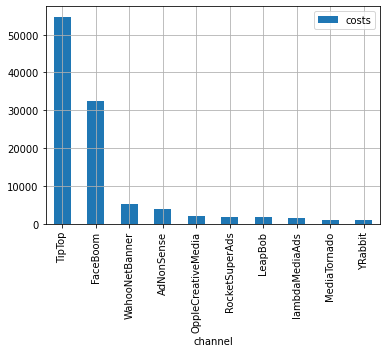

In [41]:
#Распределение трат по рекламным источникам
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False).plot.bar(grid=True);

In [42]:
#Дополнительная таблица с числовыми значениями
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


#### Микровывод:

По барплоту мы видим, что наибольшее кол-во средств компания тратит на источник рекламы Tip Top (более 50 % от всех трат). На втором месте FaceBoom. Все остальные источники задействуются по остаточному принципу и серьезно отстают от двух первых.

Возвращаясь к таблице кол-ва привлеченных пользователей по каналам рекламы, мы замечаем, что и вправду Tip Top и FaceBoom привлекают наибольшее кол-во посетителей сайта, однако, Tip Top серьезно отстает по проценту покупателей среди посетителей не только от FaceBoom, но также и от AdNonSense и lambdaMediaAds.
В связи с этим возникает резонный вопрос: оправданы ли затраты на Tip Top и его использование как главного канала рекламы?

In [43]:
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [44]:
costs['month']= pd.to_datetime(costs['dt']).dt.month

In [45]:
costs['week']= pd.to_datetime(costs['dt']).dt.week

/tmp/ipykernel_83/1887385108.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  costs['week']= pd.to_datetime(costs['dt']).dt.week


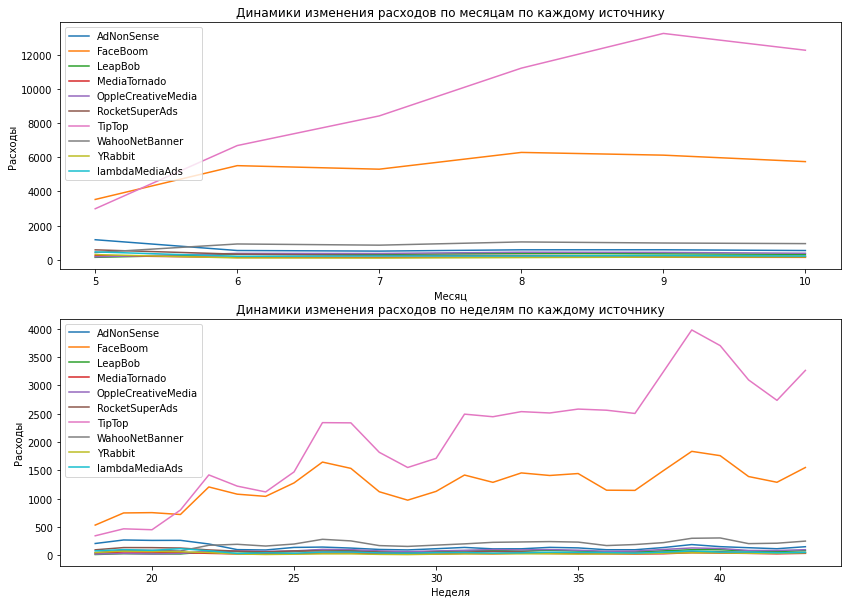

In [46]:
plt.figure(figsize = (20, 6))                 

costs.pivot_table(values='costs', index = 'channel', columns='month', aggfunc=np.sum).T.plot(label=True, figsize=(14,10), ax=plt.subplot(2, 1, 1))
plt.legend(loc=2)
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.title('Динамики изменения расходов по месяцам по каждому источнику')
costs.pivot_table(values='costs', index = 'channel', columns='week', aggfunc=np.sum).T.plot(label=True, figsize=(14,10), ax=plt.subplot(2, 1, 2))
plt.legend(loc=2)
plt.xlabel('Неделя')
plt.ylabel('Расходы')
plt.title('Динамики изменения расходов по неделям по каждому источнику')
plt.show()

На данном графике плохо видна динамика изменения расходов на большинство каналов рекламы, помимо главных. Предлагаю масштабировать графики для лучшего анализа тенденций более мелких каналов рекламы.

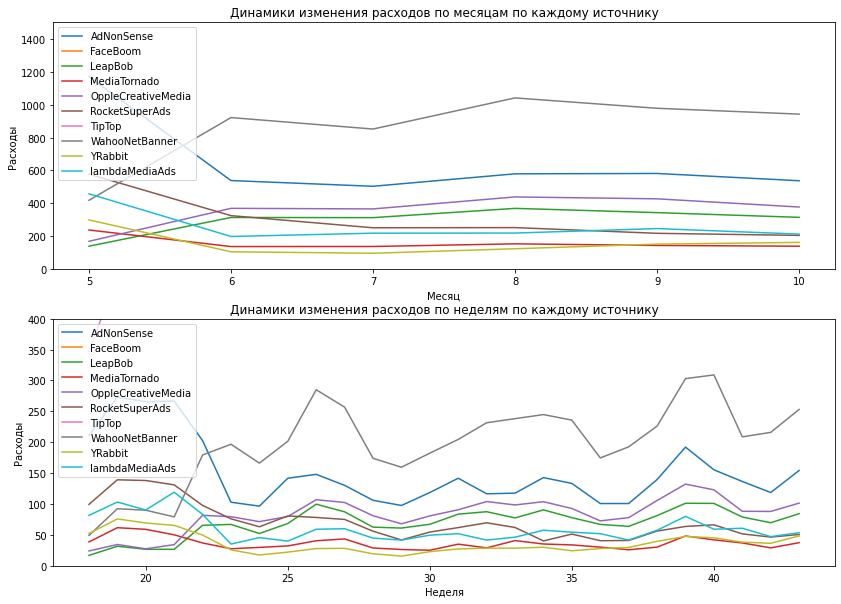

In [47]:
plt.figure(figsize = (20, 6))                 

costs.pivot_table(values='costs', index = 'channel', columns='month', aggfunc=np.sum).T.plot(label=True, figsize=(14,10), ax=plt.subplot(2, 1, 1))
plt.legend(loc=2)
plt.ylim((0,1500))
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.title('Динамики изменения расходов по месяцам по каждому источнику')
costs.pivot_table(values='costs', index = 'channel', columns='week', aggfunc=np.sum).T.plot(label=True, figsize=(14,10), ax=plt.subplot(2, 1, 2))
plt.legend(loc=2)
plt.xlabel('Неделя')
plt.ylabel('Расходы')
plt.ylim((0,400))
plt.title('Динамики изменения расходов по неделям по каждому источнику')
plt.show()

#### Микровывод:
По графикам динамики изменения расходов на разные каналы по времени, мы замечаем что в масштабах месяца динамика довольно стабильна для всех каналов рекламы. Также отметим, что в 5ый и 6ой месяца компания тратила практически одинаковую сумму на FaceBoom и TipTop, однако что-то побудило руководство компании со временем увеличивать расходы именно на TipTop.

Изменения имеют цикличный характер. Это нам мало о чем говорит. По графикам видно, что после очередного снижения расходы на все каналы рекламы идут вверх. По графику также видно, что динамика расходов на все каналы рекламы носит общий синхронный характер.

In [48]:
#Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

tabl_of_cac = profiles.groupby('channel').agg({'user_id':'nunique'}).merge(costs.groupby('channel').\
        agg({'costs':'sum'}), on='channel', how='inner')
tabl_of_cac['cac']=tabl_of_cac['costs'].div(tabl_of_cac['user_id'])
tabl_of_cac= tabl_of_cac.sort_values(by='cac', ascending=False)
tabl_of_cac.rename(columns = {'user_id' : 'count_of_users'}, inplace = True) 
tabl_of_cac

,count_of_users,costs,cac
channel,,,
TipTop,19561,54751.30,2.799003
FaceBoom,29144,32445.60,1.113286
AdNonSense,3880,3911.25,1.008054
lambdaMediaAds,2149,1557.60,0.724802
WahooNetBanner,8553,5151.00,0.602245
RocketSuperAds,4448,1833.00,0.412095
OppleCreativeMedia,8605,2151.25,0.250000
YRabbit,4312,944.22,0.218975
MediaTornado,4364,954.48,0.218717


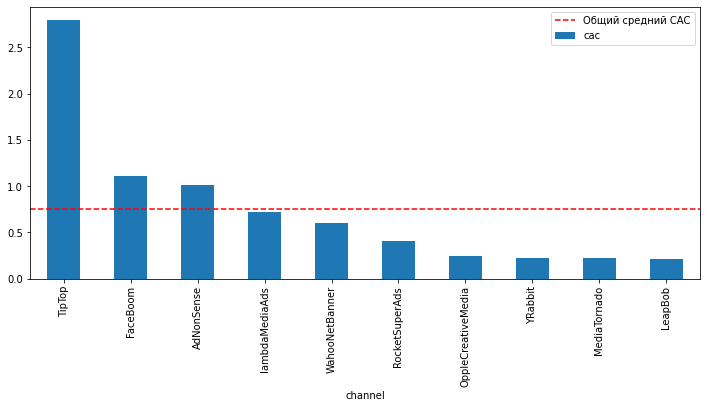

In [49]:
tabl_of_cac['cac'].plot(kind='bar', figsize=(12,5));
plt.axhline(y=tabl_of_cac['cac'].mean(), color='red', linestyle='--', label='Общий средний CAC');
plt.legend();

#### Микровывод:

На графике мы видим, что Tip Top не очень выгодный канал рекламы, так как привлечение одного пользователя стоит очень дорого. Не особо также выгодны FaceBoom и AdNonSense. Наиболее "дешевые" пользователи приходят из каналов, в которые мы почти не вкладываемся - LeapBob, MediaTomado, YRabbit.

#### Вывод по маркетингу:
1)Более половины расходов на маркетинг уходят на канал TipTop и расходы на него со временем растут, однако стоимость привлечения пользователей (CAC) у данного канала довольно высокий. То есть канал невыгодный.

2)около 85% расходов идет на TipTop и FaceBoom - каналы с стоимостью привлечения клиентов выше среднего. Расходы на остальные каналы распределяются по остаточному принципу.

3)С точки зрения стоимости привлечения пользователей (CAC) особой выгодой обладают LeapBob, MediaTornado, YRabbit, OppleCreativeMedia.

4)Расходы на каналы привлечения сохраняются на одном уровне в масштабе месяца, кроме TipTop (расходы на него растут)

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

In [50]:
#ставим дату момента анализа
observation_date = datetime(2019,11,1).date()

In [51]:
#для анализа бизнес-показателей убираем пользователей, которые сами пришли на канал
profiles = profiles.loc[profiles['channel']!='organic']

In [52]:
#cчитаем ltv и roi
horizon_days = 14
ltv_raw, ltv_grouped,ltv_in_time, roi_grouped,roi_in_time = get_ltv(profiles.loc[profiles['channel']!='organic'],
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

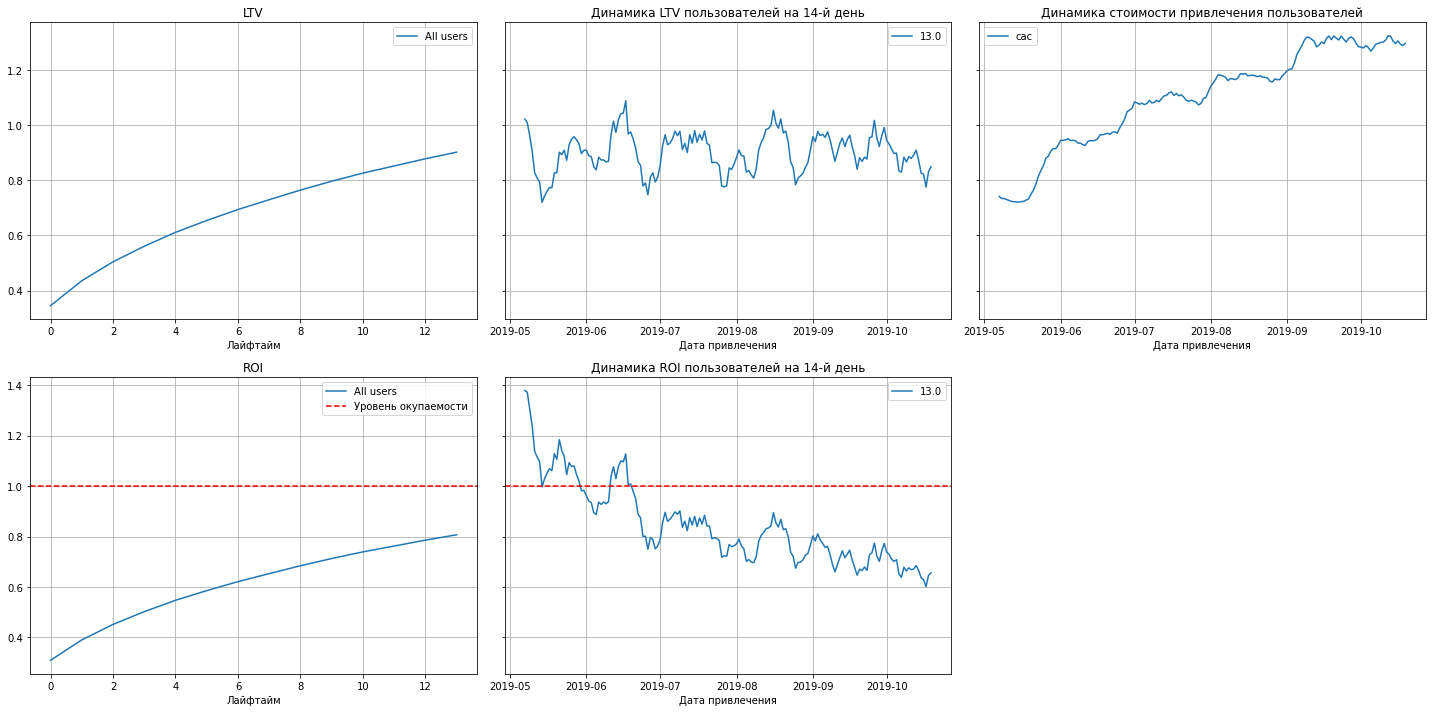

In [53]:
#строим графики динамики LTV, CAC и ROI
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

!!! В целом, реклама не окупается, и дорожает каждый месяц.

#### Микровывод:

По данным графикам можно сделать следующие выводы:
1)реклама вообщем не окупается, однако если посмотреть на динамику roi, то заметим, что в мае и июне реклама еще окупалась, но постепенно доходность падала.

2)LTV более-менее находится на одном уровне (от 0.7 до 1.0), то есть четкого тренда на снижение или рост нет

3)Стоимость привлечения пользователя растет

Исходя из этих трех пунктов, делаем вывод, что реклама перестала окупаться(roi) в связи с ростом стоимости привлечения пользователей (cac).

In [54]:
#считаем конверсию с разбивкой по устройствам
conversion_raw, conversion_grouped_on_device, conversion_in_time  = get_conversion(
    profiles,
    orders,  
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

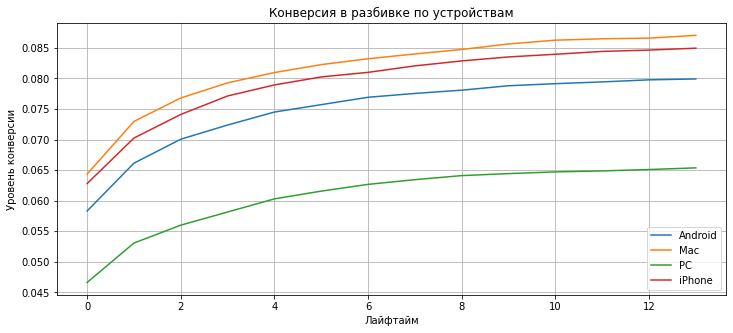

In [55]:
conversion_grouped_on_device.drop(columns='cohort_size').T.plot(grid=True, figsize=(12,5));
plt.legend(loc=4);
plt.title('Конверсия в разбивке по устройствам');
plt.xlabel('Лайфтайм');
plt.ylabel('Уровень конверсии');

Лучше конвертируются пользователи, заходящие на сайт с MacBook, хуже всего с PC (серьезно отстает). Не совсем понятен этот момент, так как и первое и второе по сути компьютеры, то есть этот разрыв мы не можем объяснить удобством того или иного устройство для покупки. У меня есть две гипотезы: а)интерфейс нашего сайта намного хуже на PC, чем на остальных устройствах; б)владельцы MacBook и IPhone в среднем состоятельнее, чем пользователи Android и PC.

In [56]:
#считаем конверсию с разбивкой по странам
conversion_raw, conversion_grouped_on_region, conversion_in_time  = get_conversion(
    profiles,
    orders,  
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)

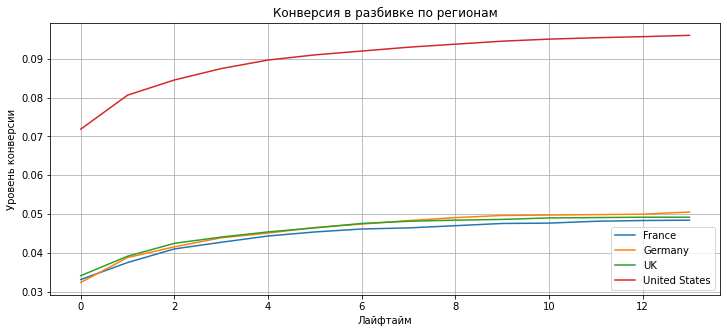

In [57]:
conversion_grouped_on_region.drop(columns='cohort_size').T.plot(grid=True, figsize=(12,5));
plt.legend(loc=4);
plt.title('Конверсия в разбивке по регионам');
plt.xlabel('Лайфтайм');
plt.ylabel('Уровень конверсии');

Конверсия пользователей в US намного лучше, чем в других странах. Это можно объяснить очень многими причинами: может быть вся наша компания больше ориентируется на США, может мы продаем продукцию в долларах, что снижает конверсию в остальных странах из-за проблем с конвертацией валют. Причин может быть много.

In [58]:
#считаем конверсию с разбивкой по рекламным каналам
conversion_raw, conversion_grouped_on_channel, conversion_in_time  = get_conversion(
    profiles,
    orders, 
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

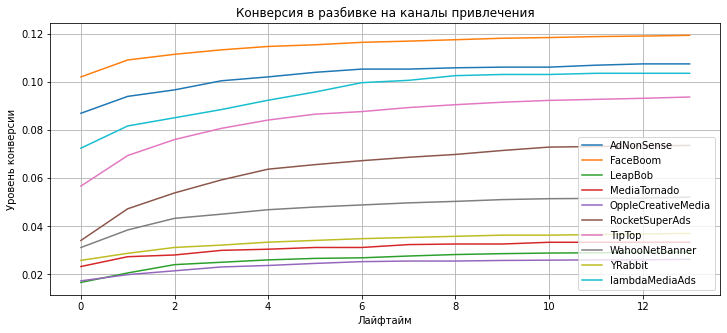

In [59]:
conversion_grouped_on_channel.drop(columns='cohort_size').T.plot(grid=True, figsize=(12,5));
plt.legend(loc=4);
plt.title('Конверсия в разбивке на каналы привлечения');
plt.xlabel('Лайфтайм');
plt.ylabel('Уровень конверсии');

3 наиболее эффективные в конверсии канала рекламы: FaceBoom, TipTop, AdNonSense. Возможно именно поэтому наша компания делает такой упор на первые два канала.

In [60]:
# считаем общую конверсию и динамику конверсии на 14ый день
conversion_raw, conversion_grouped, conversion_in_time  = get_conversion(
    profiles,
    orders,  
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

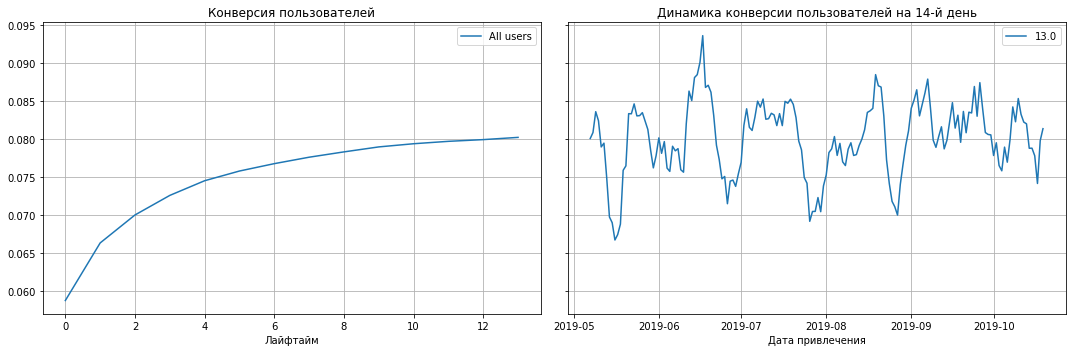

In [61]:
plot_conversion(conversion_grouped, conversion_in_time, horizon=14, window=7)

Если рассматривать конверсию без разбивки, то заметим, что функция приобретает форму гиперболы, то есть большее кол-во пользователей переходят в разряд покупателей в первые дни нежели в последние. По динамике конверсии, заметим, что на июнь и июль приходится рост конверсии среди пользователей. После июня конверсия уже не опускается ниже 0.05, хотя и имеет цикличный характер.

По графикам удержания мы замечаем: что платящие пользователи пользуются сайтом намного дольше, что логично. На 14ый день лайфтайма почти никто из неплатящих пользователей не заходит на сайт. Провалы (июль, август, ноябрь) в динамике удержания у платящих пользователей не носят какого-либо систематического характера, и, вообщем, общий уровень удержания более-менее стабилен на 14ый день.

In [62]:
# считаем удержание и динамику удержания
retention_raw, retention_grouped, retention_in_time =  get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
)

In [63]:
retention_raw, retention_grouped_on_region, retention_in_time =  get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False
)

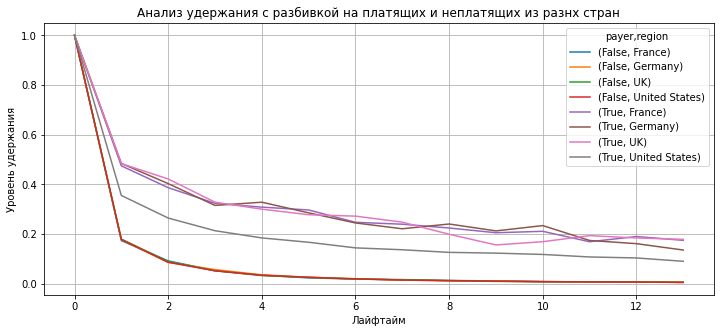

In [64]:
retention_grouped_on_region.drop(columns='cohort_size').T.plot(grid=True, figsize=(12,5));
plt.title('Анализ удержания с разбивкой на платящих и неплатящих из разнх стран');
plt.ylabel('Уровень удержания');
plt.xlabel('Лайфтайм');

In [65]:
retention_raw, retention_grouped_on_device, retention_in_time =  get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False
)

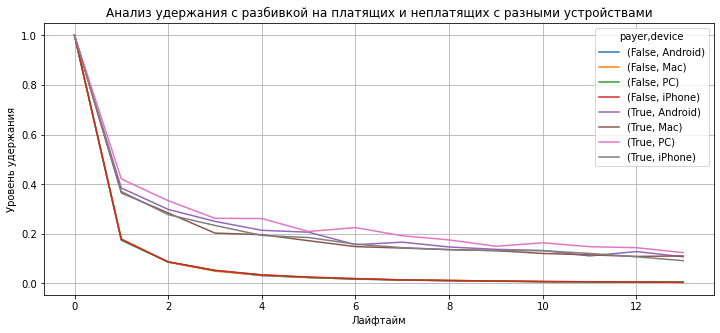

In [66]:
retention_grouped_on_device.drop(columns='cohort_size').T.plot(grid=True, figsize=(12,5));
plt.title('Анализ удержания с разбивкой на платящих и неплатящих с разными устройствами');
plt.ylabel('Уровень удержания');
plt.xlabel('Лайфтайм');

In [67]:
retention_raw, retention_grouped_on_channel, retention_in_time =  get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False
)

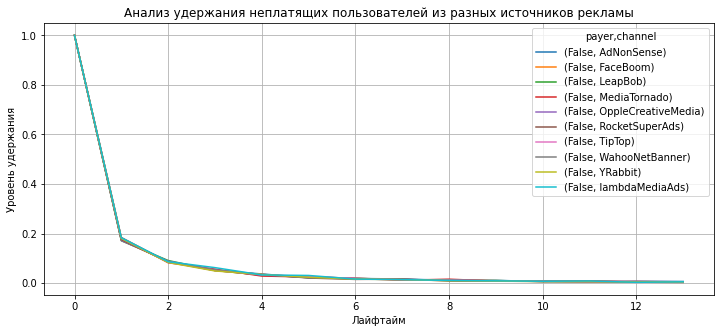

In [68]:
retention_grouped_on_channel.query('payer==False').drop(columns='cohort_size').T.plot(grid=True, figsize=(12,5));
plt.title('Анализ удержания неплатящих пользователей из разных источников рекламы');
plt.ylabel('Уровень удержания');
plt.xlabel('Лайфтайм');

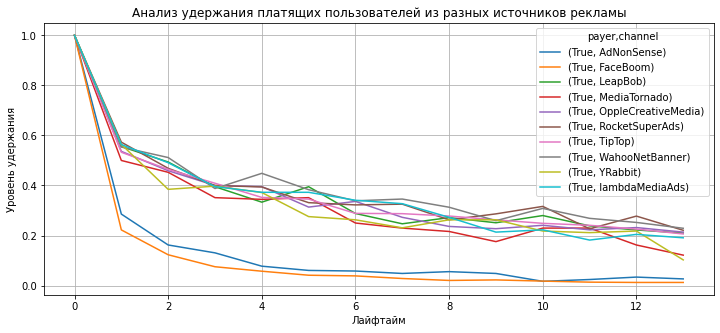

In [69]:
retention_grouped_on_channel.query('payer==True').drop(columns='cohort_size').T.plot(grid=True, figsize=(12,5));
plt.title('Анализ удержания платящих пользователей из разных источников рекламы');
plt.ylabel('Уровень удержания');
plt.xlabel('Лайфтайм');

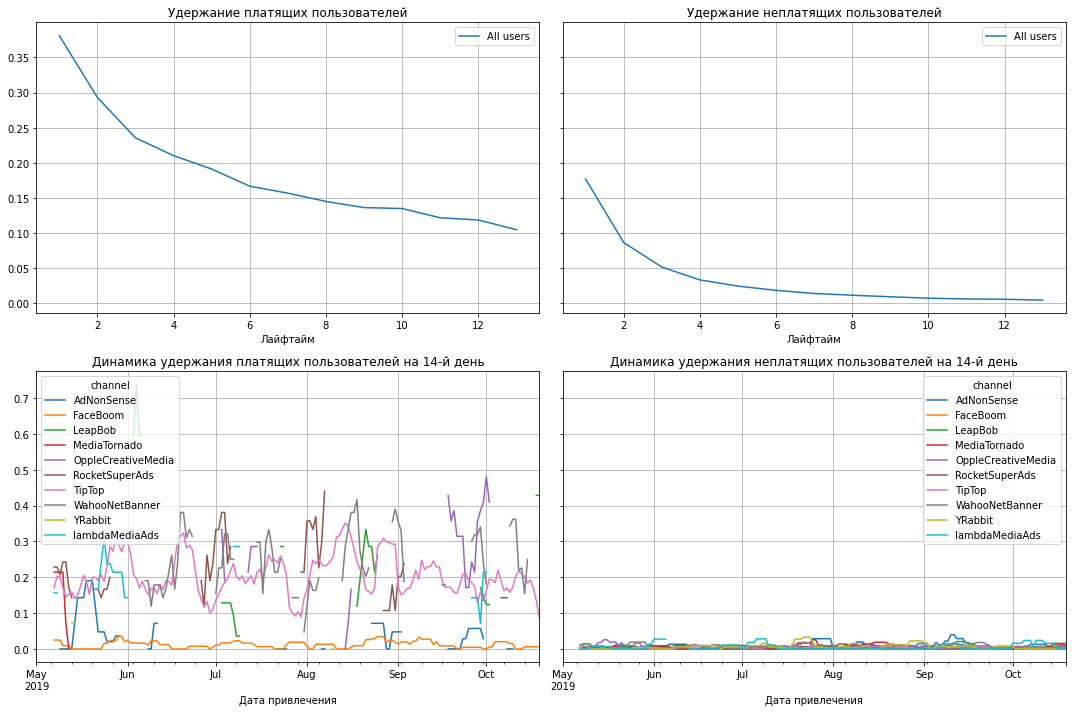

In [70]:
plot_retention(retention_grouped, retention_in_time, horizon=14, window=7)

In [71]:
#Анализируем окупаемость рекламы с разбивкой по устройствам.
horizon_days = 14
ltv_raw, ltv_grouped,ltv_in_time, roi_grouped,roi_in_time = get_ltv(profiles.loc[profiles['channel']!='organic'],
    orders,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

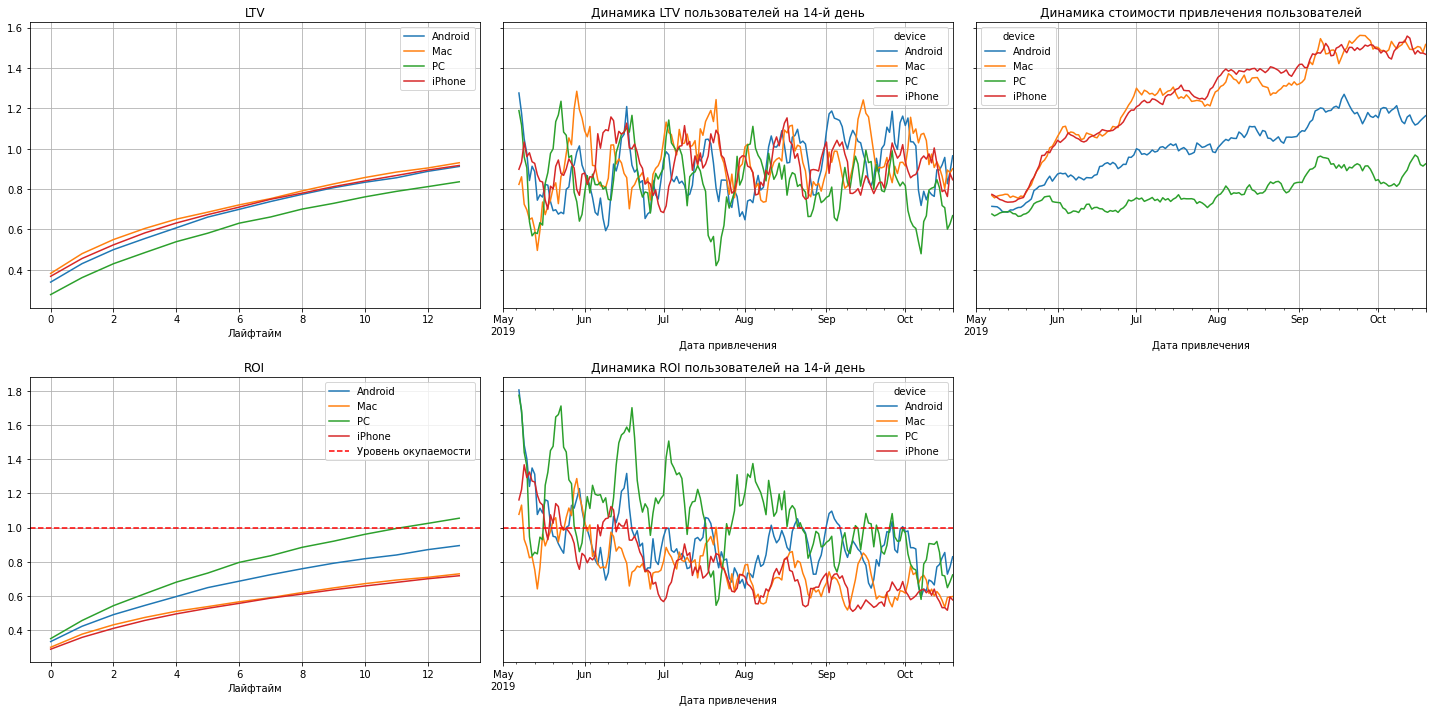

In [72]:
#Cтроим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

#### Микровывод:

1)Отметим, что LTV у всех устройств, кроме PC примерно одинаковая. PC как по конверсии (выяснили выше), так и по LTV отстает.

2)Привлекать пользователей с Mac или Android дороже чем остальных, однако, как мы видим эти пользователи имеют большуб конверсию и LTV

3)Несмотря на это (пункт 2), никакие пользователи, кроме пользователей с PC, не окупаются.

4)Хотя как мы видим, пользователи PC c сентября тоже перестали окупаться

In [73]:
#Анализируем окупаемость рекламы с разбивкой по странам.
horizon_days = 14
ltv_raw, ltv_grouped,ltv_in_time, roi_grouped,roi_in_time = get_ltv(profiles.loc[profiles['channel']!='organic'],
    orders,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)

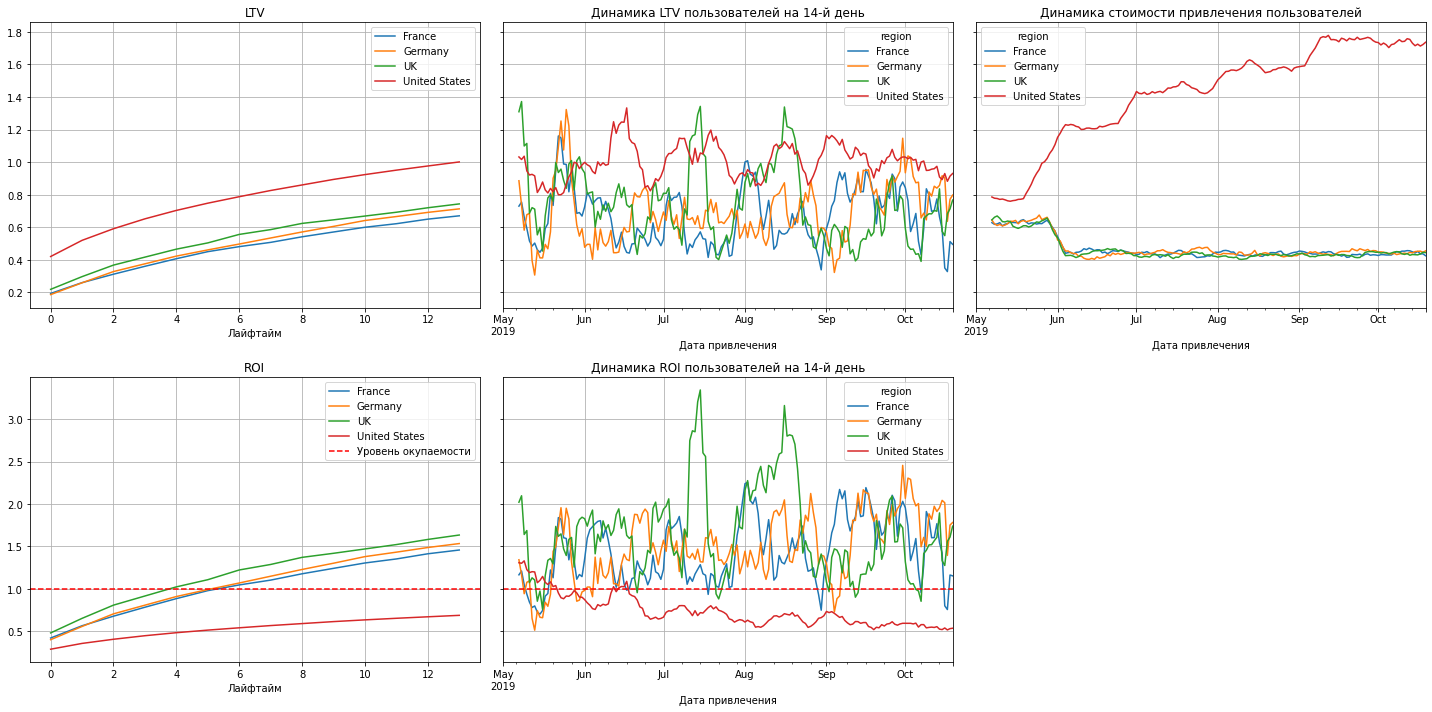

In [74]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

#### Микровывод:

1)Самый высокий LTV у США, напорядок выше, чем у остальных, последующие графики объясняют эту ситуацию

2)Стоимость привлечения пользователей из США серьезно превышает пользователей из остальных стран. И эта стоимость растет

3)На графике ROI мы видим, что привлечение пользователей из всех стран, кроме USA, окупается. С этой токи зрения, выгоднее всего вкладываться в пользователей из UK.

##### Анализ рынка США

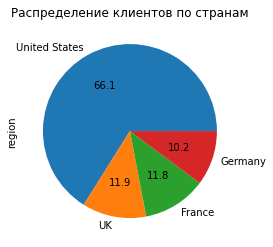

In [75]:
#общая доля рынка США
profiles['region'].value_counts().plot(kind='pie', autopct='%.1f');
plt.title('Распределение клиентов по странам');

66% наших клиентов из США, имеено это обсулавливает важность отдельного изучения этого рынка

In [76]:
# считаем удержание и динамику удержания в США в разбивке по устройствам
retention_raw_for_US_device, retention_grouped_for_US_device, retention_in_time_for_US_device =  get_retention(
    profiles.query('region=="United States"'),
    visits,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False
)

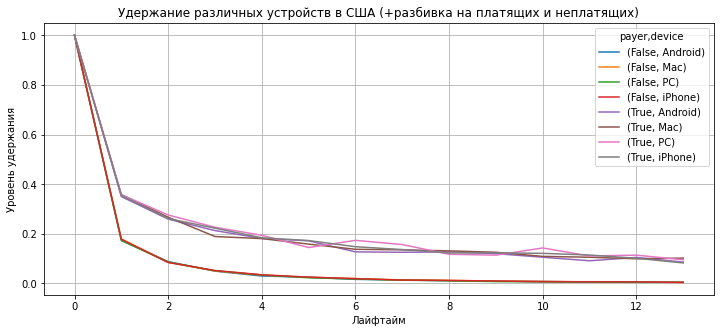

In [77]:
retention_grouped_for_US_device.drop(columns='cohort_size').T.plot(grid=True, figsize=(12,5));
plt.title('Удержание различных устройств в США (+разбивка на платящих и неплатящих)');
plt.xlabel('Лайфтайм');
plt.ylabel('Уровень удержания');

Серьезных отличий от общего удержания не наблюдается. Ни одно устройство особым образом себя не проявляет.

In [78]:
# считаем удержание и динамику удержания в США в разбивке по каналам привлечения
retention_raw_for_US_channel, retention_grouped_for_US_channel, retention_in_time_for_US_channel =  get_retention(
    profiles.query('region=="United States"'),
    visits,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False
)

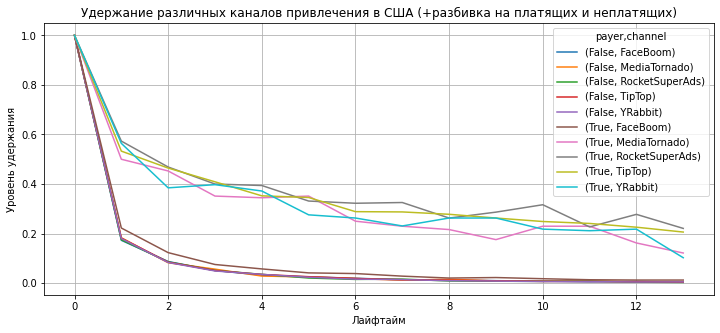

In [79]:
retention_grouped_for_US_channel.drop(columns='cohort_size').T.plot(grid=True, figsize=(12,5));
plt.title('Удержание различных каналов привлечения в США (+разбивка на платящих и неплатящих)');
plt.xlabel('Лайфтайм');
plt.ylabel('Уровень удержания');

В отличие от общей ситуации, здесь RocketSuperAds превосходит по удержанию даже TipTop. Четверка лидеров удержания в США: RocketSuperAds, TipTop, MediaTornado, Yrabbit.

In [80]:
#проанализируем конверсию в США в разбивке по устройствам
conversion_raw_US_device, conversion_grouped_US_device, conversion_in_time_US_device  = get_conversion(
    profiles.query('region=="United States"'),
    orders,  
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

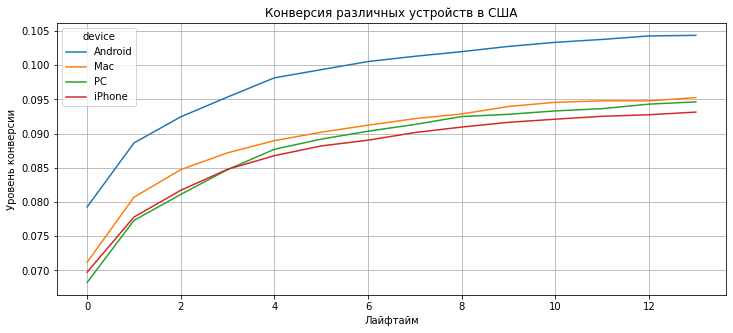

In [81]:
conversion_grouped_US_device.drop(columns='cohort_size').T.plot(grid=True, figsize=(12,5));
plt.title('Конверсия различных устройств в США');
plt.xlabel('Лайфтайм');
plt.ylabel('Уровень конверсии');

Высокая конверсия Android - это одна из особенностей рынка США. Надо ее учитывать.

In [82]:
#проанализируем конверсию в США в разбивке по каналам привлечения
conversion_raw_US_channel, conversion_grouped_US_channel, conversion_in_time_US_channel  = get_conversion(
    profiles.query('region=="United States"'),
    orders,  
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

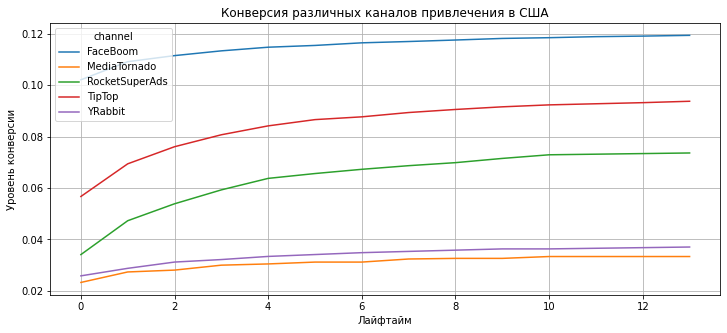

In [83]:
conversion_grouped_US_channel.drop(columns='cohort_size').T.plot(grid=True, figsize=(12,5));
plt.title('Конверсия различных каналов привлечения в США');
plt.xlabel('Лайфтайм');
plt.ylabel('Уровень конверсии');

Также как и на других рынках, в США наибольшей конверсией обладают каналы привлечения FaceBoom и TipTop.

In [84]:
#исследуем LTV, CAC, ROI для США с разбивкой по устройствам
ltv_raw_device_USA, ltv_grouped_device_USA,ltv_in_time_device_USA, roi_grouped_device_USA,roi_in_time_device_USA = get_ltv(profiles.loc[(profiles['channel']!='organic') & (profiles['region']=='United States')],
    orders,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

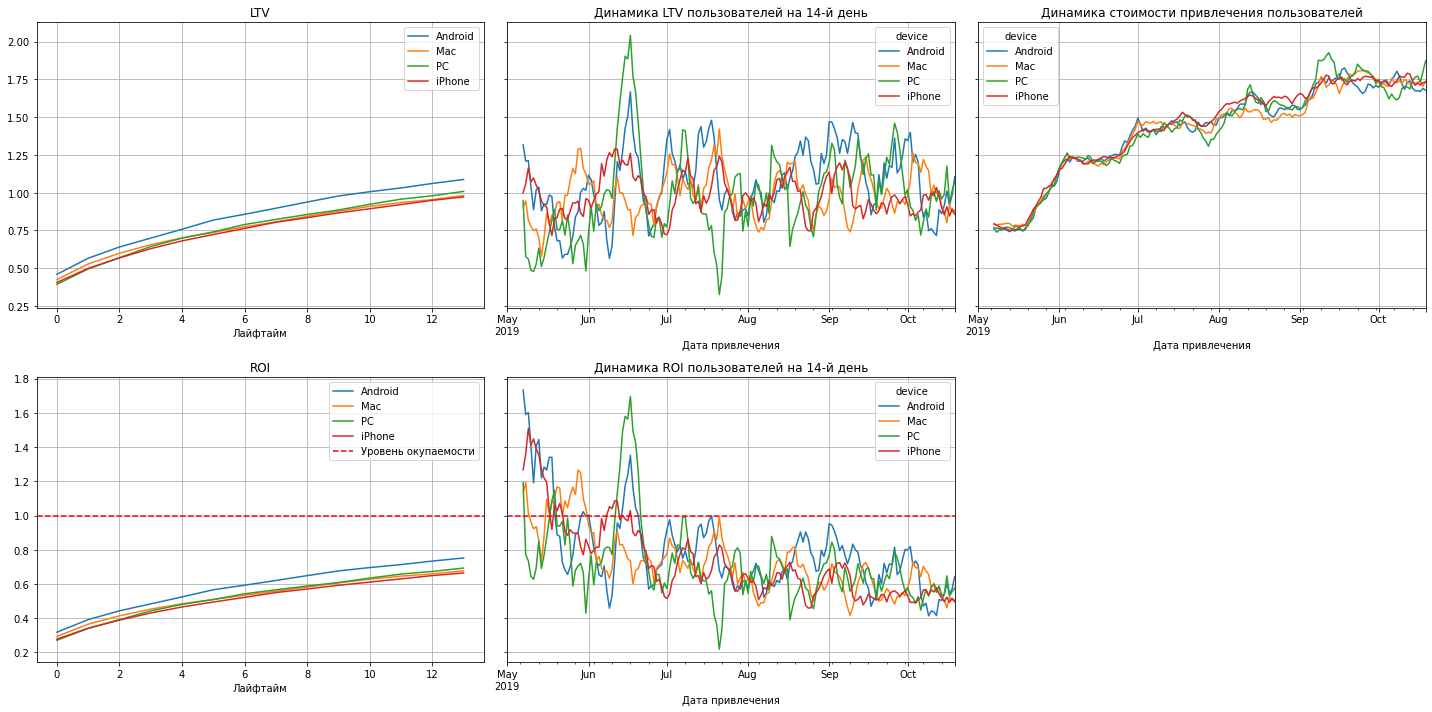

In [85]:
plot_ltv_roi(ltv_grouped_device_USA, ltv_in_time_device_USA, roi_grouped_device_USA, roi_in_time_device_USA, horizon_days)

1)Самый высокий LTV у Android в отличие от общей ситуации, где LTV самый большой у MAC.
2)Согласно CAC Android также самый выгодный, привлечение пользователей через Android наиболее дешево, а через PC наиболее дорого. А общая ситуация наоборот демонстрирует, что PC наиболее дешевая платформа с точки зрения привлечения пользователей.
3)В США привлечение пользователей не окупается ни через одну платформу.

In [86]:
#исследуем LTV, CAC, ROI для США с разбивкой по каналам
ltv_raw_channel_USA, ltv_grouped_channel_USA,ltv_in_time_channel_USA, roi_grouped_channel_USA,roi_in_time_channel_USA = get_ltv(profiles.loc[(profiles['channel']!='organic') & (profiles['region']=='United States')],
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

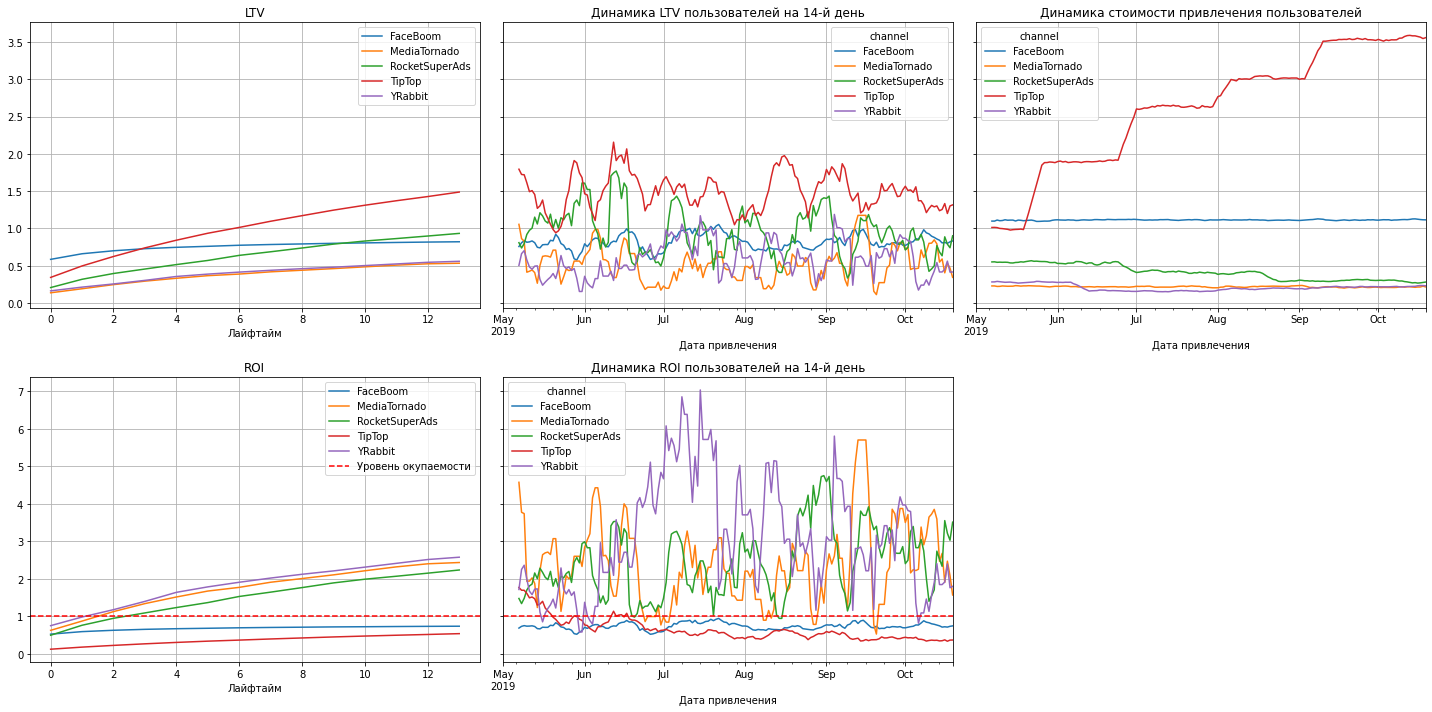

In [87]:
plot_ltv_roi(ltv_grouped_channel_USA, ltv_in_time_channel_USA, roi_grouped_channel_USA, roi_in_time_channel_USA, horizon_days)

1)Наибольший LTV в США у TipTop, второе место-RocketSuperAds, в отличие от общей ситуации, где lambdaMediaAds имеет наибольший LTV

2)Затраты на привлечение наибольшие у TipTop и растут они довольно резко. Самые дешевые по затратам каналы: RocketSuperAds, YRabbit, MediaTornado

3)По ROI оупаются RocketSuperAds, YRabbit, MediaTornado.

!Рекомендация по США сделать акцент на каналы привлечения RocketSuperAds, YRabbit, MediaTornado и отойти от  приоритетного использования TipTop. В плане устройств наибольшеее внимание уделить Android.

!!!КОНЕЦ АНАЛИЗА РЫНКА США

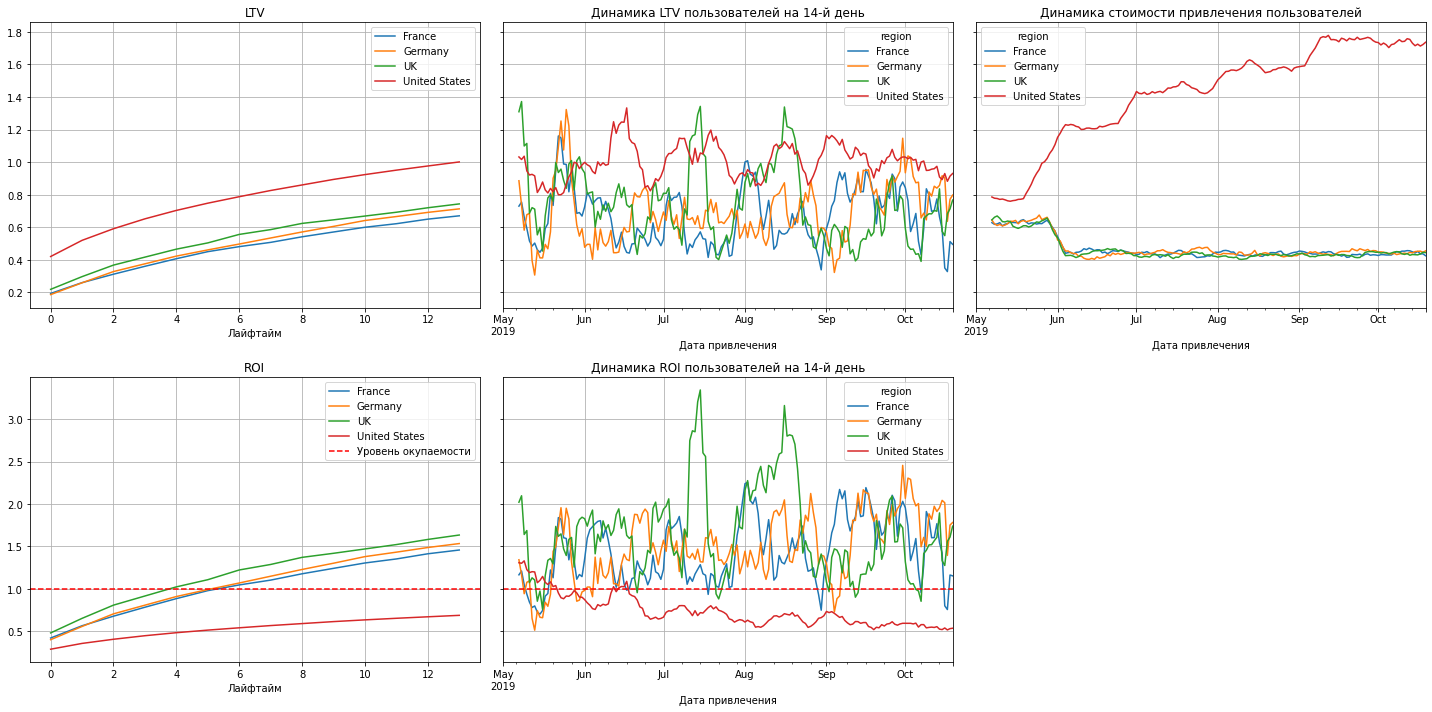

In [88]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

In [89]:
#Анализируем окупаемость рекламы с разбивкой по каналам привлечения.
horizon_days = 14
ltv_raw, ltv_grouped,ltv_in_time, roi_grouped,roi_in_time = get_ltv(profiles.loc[profiles['channel']!='organic'],
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

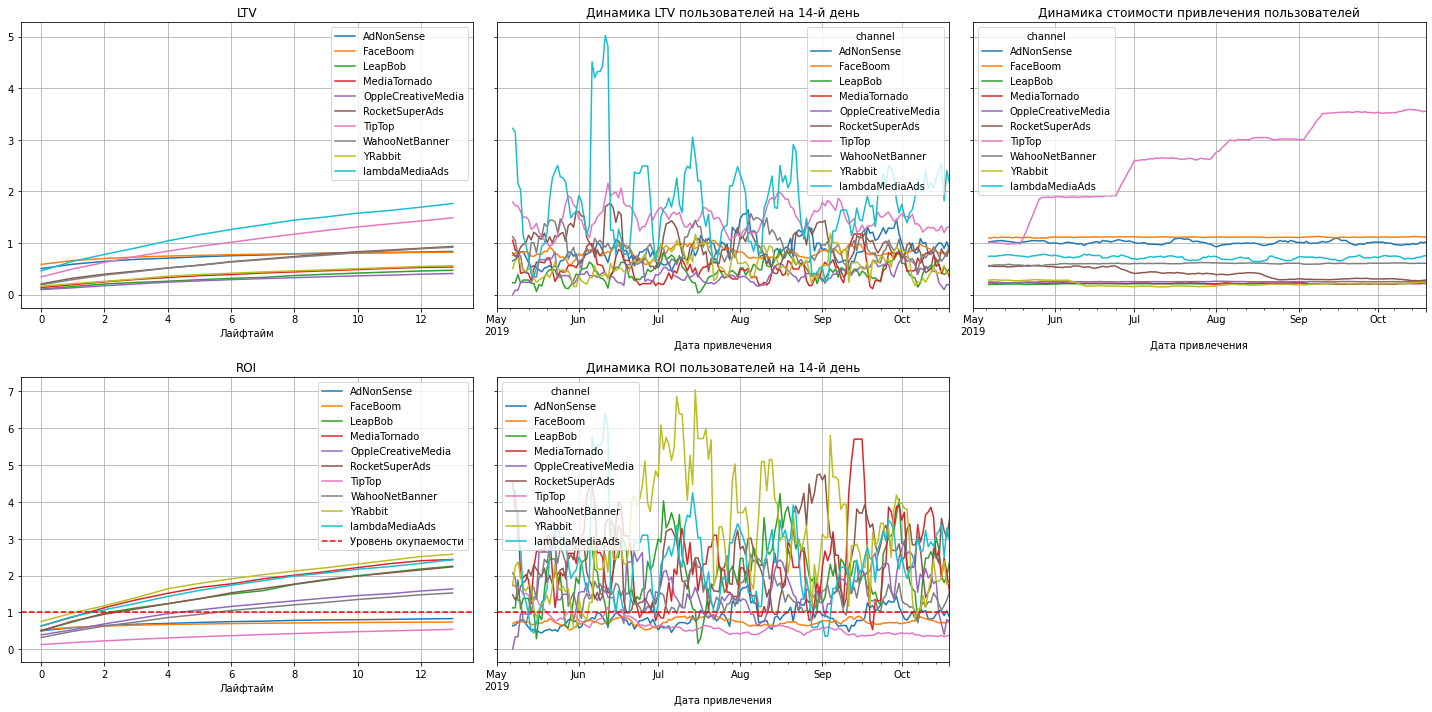

In [90]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

#### Микровывод:

1)C точки зрения LTV, наиболее позитивно себя показывают lambdaMediaAds (канал, в который компания почти не вкладывается) и TipTop (главный канал рекламы для нашей компании).

2)Однако TipTop крайне невыгоден с точки зрения стоимости привлечения пользователей в отличие от lambdaMediaAds. При этом стоимость привлечения по TipTop дорожает с каждый месяцем.

3)Таким образом, по ROI мы видим, что TipTop вообще не окупается.

4)Такие каналы привлечения как YRabbit, Media Tornado, RocketSuperAds, lambdaMediaAds показывает очень высокий ROI (больше 2), то есть окупаются больше чем в 2 раза. Надо это взять на заметку

5)Можно также выделить три неокупающиxся канала: lambdaMediaAds, FaceBoom, TipTop

6)Негативное влияние на рекаму в целом оказывают: устройства: Iphone, Mac; страны: US; каналы привлечения: TipTop, FaceBoom, AdNonSense.

!Рекомендация: сменить канал привлечения пользователей.

#### Вывод:
Если говорить о причинах проблем с окупаемостью, то у меня возникает следующее подозрение:
Гипотеза 1:
Вероятно, имеется некоторый оптимальный уровень капиталовложений в определенный канал привлечения, в рапространение на территории определенной страны, в акценте на определенное устройство, при котором достигается максимально возможный ROI. Когда вложения идут сверх этого уровня, то они уже не имеют такого эффекта и не окупается. Если следовать данной логике, мы видим, что и TipTop, USA, MAC в мае и июне еще окупались.Наверное, из-за этого руководство компании сделало огромный акцент на этих направлениях, и при росте расходов, LTV расти не стал. То есть данная гипотеза довольно жизнеспособная.

(Для подтверждения данной гипотезы,я внизу построил графики изменения трат на каналы, страны и устройства)

Гипотеза 2:
Возможно, эти направления изначально были выгодны, но потом стали дорожать в силу повышения цен на рекламу по этим каналам, и по стране USA. То есть просто подорожала реклама на направлениях, которые являлись нашими основными.

!Какая бы гипотеза не была верна, рекомендации похожие:

Рекомендации: диверсифицировать каналы привлечения, страны и устройства, в которые мы вкладываемся. Вкладывать 90% средств не в одну страну, один канал привлечения, одно устройство, а сразу в несколько в равной степени. То есть, например, среди каналов привлечения, можно задействовать такие как lambdaMediaSense, YRabbit, MediaTornado, RocketSuperAds (у которых "волшебный" Roi); среди стран, начать вкладываться в Великобританию и другие, а среди устройств сделать акцент на пользователях PC (единственное устройство, которое "окупается").

In [91]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,5,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,7,False,1.107237
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,8,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,10,False,0.230769
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,6,True,1.008000


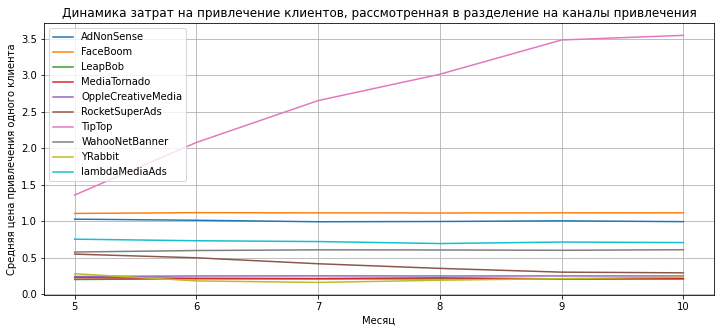

In [92]:
profiles.pivot_table(index='month', columns='channel', values='acquisition_cost', aggfunc='mean')\
.plot(grid=True, figsize=(12,5));
plt.legend(loc=2);
plt.title('Динамика затрат на привлечение клиентов, рассмотренная в разделение на каналы привлечения');
plt.xlabel('Месяц');
plt.ylabel('Средняя цена привлечения одного клиента');

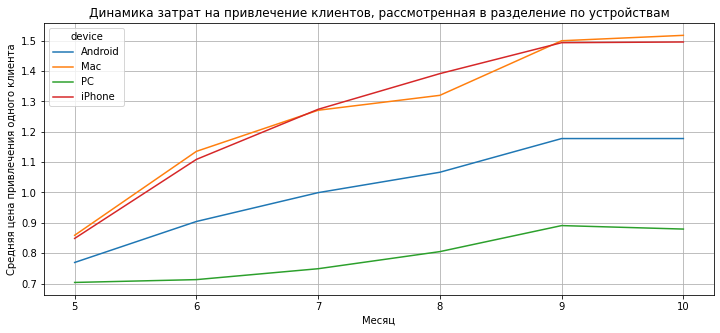

In [93]:
profiles.pivot_table(index='month', columns='device', values='acquisition_cost', aggfunc='mean')\
.plot(grid=True, figsize=(12,5));
plt.title('Динамика затрат на привлечение клиентов, рассмотренная в разделение по устройствам');
plt.xlabel('Месяц');
plt.ylabel('Средняя цена привлечения одного клиента');

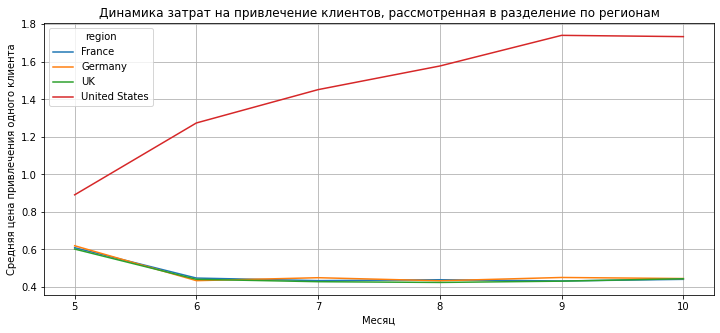

In [94]:
profiles.pivot_table(index='month', columns='region', values='acquisition_cost', aggfunc='mean')\
.plot(grid=True, figsize=(12,5));
plt.title('Динамика затрат на привлечение клиентов, рассмотренная в разделение по регионам');
plt.xlabel('Месяц');
plt.ylabel('Средняя цена привлечения одного клиента');

####  Интересное наблюдение:

Несмотря на то, что наши основные каналы (TipTop, FaceBoom) не окупаются, они превосходят все остальные по конверсии. Хотя казалось бы между этими показателями должна быть положительная взаимосвязь. Вероятно, высокая конверсия является следствием рекламы. Таким образом, встает вопрос об эффекте рекламы: она увеличивает количество пользователей, либо увеличивает конверсию ("покупаемость"), или реклама действует как количественно, так и качественно??

In [95]:
costs.groupby('channel')['costs'].agg('mean')

channel
AdNonSense             21.729167
FaceBoom              180.253333
LeapBob                 9.986667
MediaTornado            5.302667
OppleCreativeMedia     11.951389
RocketSuperAds         10.183333
TipTop                304.173889
WahooNetBanner         28.616667
YRabbit                 5.245667
lambdaMediaAds          8.653333
Name: costs, dtype: float64

In [96]:
ratio_users_channel

,count_users,piece_payers
channel,,
organic,56439,0.020553
FaceBoom,29144,0.122049
TipTop,19561,0.096007
OppleCreativeMedia,8605,0.027077
LeapBob,8553,0.030633
WahooNetBanner,8553,0.052964
RocketSuperAds,4448,0.079137
MediaTornado,4364,0.035747
YRabbit,4312,0.038265


In [97]:
#исключим organic, так как эт пользователи сломают нам весь расчет корреляции
ratio_users_channel.query('channel!="organic"')

,count_users,piece_payers
channel,,
FaceBoom,29144,0.122049
TipTop,19561,0.096007
OppleCreativeMedia,8605,0.027077
LeapBob,8553,0.030633
WahooNetBanner,8553,0.052964
RocketSuperAds,4448,0.079137
MediaTornado,4364,0.035747
YRabbit,4312,0.038265
AdNonSense,3880,0.113402


In [98]:
#соединим таблицу затрат и таблицу конверсии разных рекламных каналов и посчитаем корреляцию
ratio_users_channel.query('channel!="organic"').merge(costs.groupby('channel')['costs'].agg('mean'), on='channel',\
                how='outer')[['piece_payers', 'costs']].corr(method='pearson')


,piece_payers,costs
piece_payers,1.000000,0.498463
costs,0.498463,1.000000


In [99]:
piece_payers_and_costs=ratio_users_channel.query('channel!="organic"').merge(costs.groupby('channel')['costs'].agg('mean'),\
        on='channel', how='outer')[['piece_payers', 'costs']]

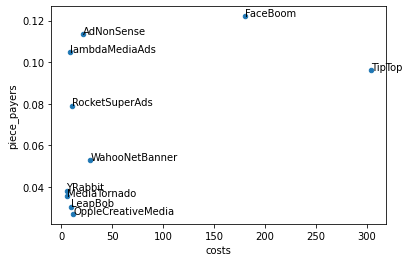

In [100]:
#построим скеттер плот для понимания общей картины
piece_payers_and_costs.plot(x='costs', y='piece_payers', kind='scatter');
for i in piece_payers_and_costs.index.to_list():
    plt.annotate(i,(float(piece_payers_and_costs.query('channel==@i')['costs']),\
                    float(piece_payers_and_costs.query('channel==@i')['piece_payers'])))

Говорить о полной причинно-следственной связи нельзя, так как, во-первых, это корреляция, во-вторых, огромную конверсию имеют и каналы, в которые мы не вкладываемся. Скорее всего, компания пытается вкладываться в каналы, имеющие большую конверсию, и конверсия не является следствием инвестиций. Но мы видим, что TipTop (самая правая точка) имеет не самую высокую конверсию, однако, компания в нее вкладывает огромные деньги. Думаю, это проблема!

# Выводы:
Как мы выяснили, реклама не окупается (низкий Roi). Связано это с ориентированием вложений компании в рекламные каналы с низким ROI (TipTop, FaceBoom), в один регион (US), вложения в который также не окупаются. Также мы видим, что только реклама на платформу PC окупается (хоть у него низкая конверсия, также и cac тоже низкий), хотя на данной платформе не так много пользователей нашего приложения. 

Причина снижения окупаемости:
1)TipTip (наш основной канал) не окупается вследствие постоянно растущей стоимости привлечения (CAC). Таким образом, с каждым месяцем расходы растут благодаря днамике данного канала.

2)FaceBoom и AdNonSense не окупаются из-за низкого LTV и превышающей LTV стоимости привлечения клиентов (CAC).

3)На рынке США вся реклама терпит убытки, вследствие того, что ни на одном устройстве реклама не окупается и стоимость привлечения (CAC) на всех устройствах быстро растет. TipTop и FaceBoom в США тоже не окупается по тем же причинам, что были перечислены выше.

4)В мировом масштабе реклама ни на одном устройстве не окупается из-за постонно растущей стоимости привлечения (CAC) всех устройств. Месяц назад PC еще окупался, однако на данный момент перестал.

5)Около 85% наших расходов на рекламу уходят на неокупающиеся каналы TipTop и FaceBoom, а на выгодные каналы привлечения (Yrabbit, MediaTornado, RocketSuperAds, lambdaMediaAds) комания средств почти не выделяет.

Рекомендации:

1)В большой степени пользоваться такими рекламными каналами, как Yrabbit, MediaTornado, RocketSuperAds, lambdaMediaAds, так как Roi у них больше 1, иногда и больше 2.

2)Снизить втрое затраты на TipTop и FaceBoom и перенаправить освободившиеся средства на вышеуказанные каналы

3)Активизировать рекламные компании в странах Европы (Германия, Великобритания, Франция). Снизить затраты на рекламные компании в США и перенаправить средства в вышеуказанные страны. Так как в США расходы на рекламу на всех устройствах растут и прекращение данного роста пока ожидать не приходится.

4)Соориентировать отдел маркетинга на оптимизацию рекламы на PC (может быть поправить интерфейс, сделать ее удобнее). Ну вообщем поработать над ней именно применимо к этому устройству. Также желательно провести данную работу касательно Android. Так как Android обладает наибольшим ROI в США (самый большой рынок нашей компании).

Благодаря выполнению этих пунктов, мы выйдим в плюс.